In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import tensorflow as tf

# Load the CSV file
data = pd.read_csv('/kaggle/input/iotbpm/augmented_data.csv')

# Separate the features and target variables
X_geometry = data['Geometry-Dash'].values.reshape(-1, 1)
y_geometry = data['Geometry-Dash']
X_clash = data['Clash-Royale'].values.reshape(-1, 1)
y_clash = data['Clash-Royale']

# Split the data into training and testing sets
X_geometry_train, X_geometry_test, y_geometry_train, y_geometry_test = train_test_split(X_geometry, y_geometry, test_size=0.2, random_state=42)
X_clash_train, X_clash_test, y_clash_train, y_clash_test = train_test_split(X_clash, y_clash, test_size=0.2, random_state=42)

# Create and train the linear regression models
geometry_model = LinearRegression()
clash_model = LinearRegression()

# Use the GPU for computations
with tf.device('/device:GPU:0'):
    geometry_model.fit(X_geometry_train, y_geometry_train)
    clash_model.fit(X_clash_train, y_clash_train)

# Make predictions on the test set
y_geometry_pred = geometry_model.predict(X_geometry_test)
y_clash_pred = clash_model.predict(X_clash_test)

# Evaluate the model performance
geometry_mse = mean_squared_error(y_geometry_test, y_geometry_pred)
geometry_r2 = r2_score(y_geometry_test, y_geometry_pred)
clash_mse = mean_squared_error(y_clash_test, y_clash_pred)
clash_r2 = r2_score(y_clash_test, y_clash_pred)

In [5]:
print('Geometry-Dash: Mean Squared Error:', geometry_mse, 'R-squared:', geometry_r2)
print('Clash-Royale: Mean Squared Error:', clash_mse, 'R-squared:', clash_r2)

Geometry-Dash: Mean Squared Error: 7.434225170802815e-29 R-squared: 1.0
Clash-Royale: Mean Squared Error: 8.19900373030924e-29 R-squared: 1.0


([<matplotlib.axis.YTick at 0x7afcf053d300>,
 [Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90'),
  Text(0, 100, '100'),
  Text(0, 110, '110'),
  Text(0, 120, '120'),
  Text(0, 130, '130'),
  Text(0, 140, '140'),
  Text(0, 150, '150')])

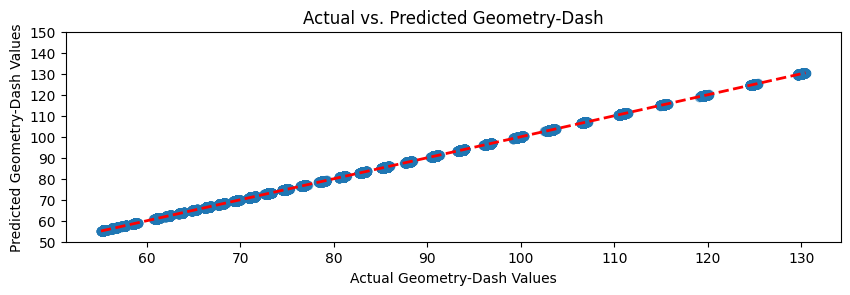

In [8]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(y_geometry_test, y_geometry_pred, alpha=0.5)
plt.plot([min(y_geometry_test), max(y_geometry_test)], [min(y_geometry_test), max(y_geometry_test)], 'r--', linewidth=2)
plt.xlabel('Actual Geometry-Dash Values')
plt.ylabel('Predicted Geometry-Dash Values')
plt.title('Actual vs. Predicted Geometry-Dash')
plt.ylim(50, 150)  # Adjust the y-axis range
plt.yticks(range(50, 151, 10))  

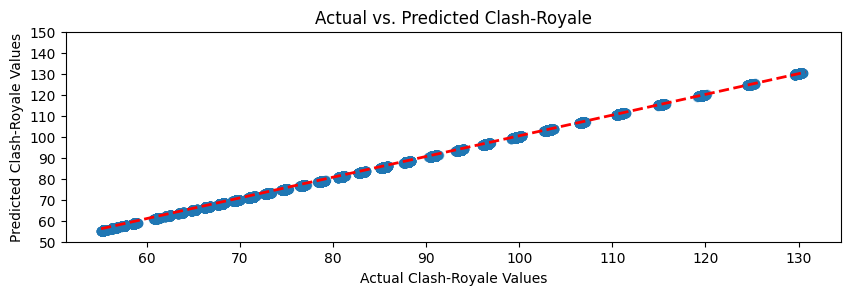

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(y_geometry_test, y_geometry_pred, alpha=0.5)
plt.plot([min(y_geometry_test), max(y_clash_test)], [min(y_clash_test), max(y_clash_test)], 'r--', linewidth=2)
plt.xlabel('Actual Clash-Royale Values')
plt.ylabel('Predicted Clash-Royale Values')
plt.title('Actual vs. Predicted Clash-Royale')
plt.ylim(50, 150)  
plt.yticks(range(50, 151, 10))  
plt.show()

In [ ]:
! pip install git+https://github.com/IBM/tsfm.git
! pip install transformers

In [11]:
import pandas as pd
import torch
from transformers import PatchTSTForPrediction

# Load custom CSV file
data_path = "/kaggle/input/iotbpm/augmented_data.csv"
data = pd.read_csv(data_path)

# Assuming 'Geometry-Dash' and 'Clash-Royale' are column names
geometry_dash_values = data['Geometry-Dash'].values
clash_royale_values = data['Clash-Royale'].values

# Pad or truncate the sequences to match the model's input length (512)
max_sequence_length = 512
geometry_dash_values = torch.tensor(geometry_dash_values[:max_sequence_length], dtype=torch.float32)
clash_royale_values = torch.tensor(clash_royale_values[:max_sequence_length], dtype=torch.float32)

# Concatenate the values of both columns into a single tensor
input_values = torch.stack([geometry_dash_values, clash_royale_values], dim=1) # Shape: [sequence_length, num_channels]

model = PatchTSTForPrediction.from_pretrained("chungimungi/PatchTST-2-input-channels")

# Ensure the model is in evaluation mode
model.eval()

# During inference, one only provides past values, the model outputs future values
with torch.no_grad():
  outputs = model(past_values=input_values.unsqueeze(0)) # Add batch dimension
  prediction_outputs = outputs.prediction_outputs

# Extract predicted future values
predicted_values = prediction_outputs.squeeze(0) # Remove batch dimension

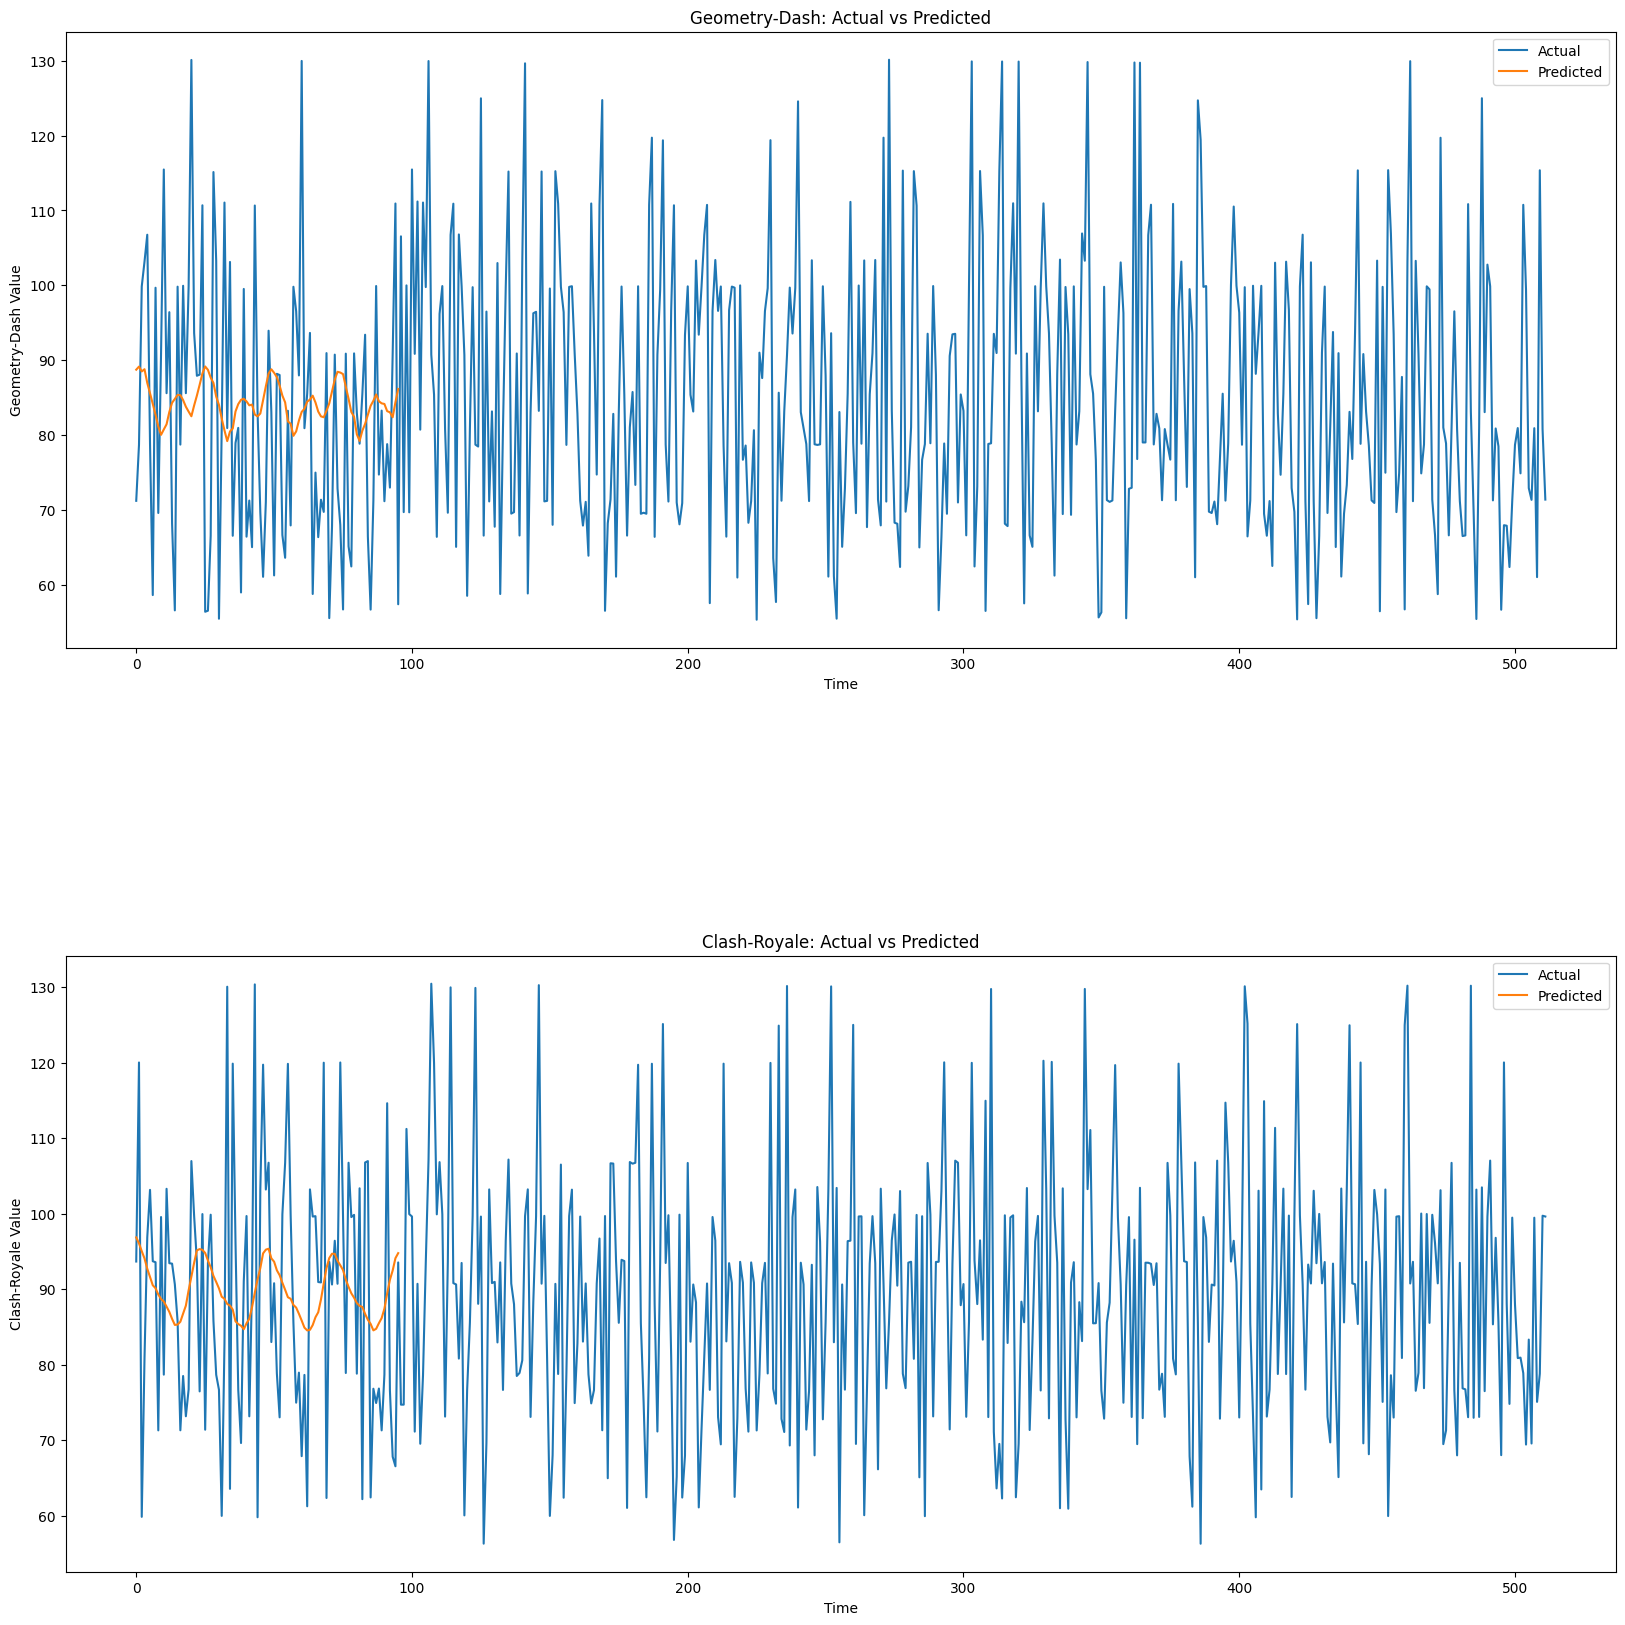

In [12]:
import matplotlib.pyplot as plt

# Use the values from the code you provided
geometry_dash_values = geometry_dash_values.numpy()
clash_royale_values = clash_royale_values.numpy()
predicted_geometry_dash = predicted_values[:, 0].numpy()
predicted_clash_royale = predicted_values[:, 1].numpy()

# Create a figure and axis for Geometry-Dash
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# Plot Geometry-Dash
ax1.plot(geometry_dash_values, label='Actual')
ax1.plot(predicted_geometry_dash, label='Predicted')
ax1.set_xlabel('Time')
ax1.set_ylabel('Geometry-Dash Value')
ax1.set_title('Geometry-Dash: Actual vs Predicted')
ax1.legend()

# Create a figure and axis for Clash-Royale
ax2.plot(clash_royale_values, label='Actual')
ax2.plot(predicted_clash_royale, label='Predicted')
ax2.set_xlabel('Time')
ax2.set_ylabel('Clash-Royale Value')
ax2.set_title('Clash-Royale: Actual vs Predicted')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()